## Expirementation with XGBoost to detect Automatically Generated Domains <b>
ML Model to detect Domain Generation Algorithm (DGA) generated Domains vs Legit domains.

In [104]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import tldextract
import sklearn.feature_extraction

from numpy import sort
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['axes.grid'] = True

sns.set()
%matplotlib inline


In [105]:
# This is the Alexa 100k domain list, we're not using the 1 Million just for speed reasons. Results
# for the Alexa 1M are given at the bottom of the notebook.
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head()

,rank,uri
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


In [106]:
def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (ext.suffix):
        return ext.domain
    return np.nan
        
alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
print(alexa_dataframe.shape)
alexa_dataframe.head()

(100000, 1)


,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [107]:
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()
alexa_dataframe['class'] = 'legit'
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_dataframe.head()

,domain,class
28503,cfanclub,legit
95207,bjxueche,legit
94517,swiftkey,legit
69580,havertys,legit
45264,phila,legit


In [108]:
alexa_dataframe.shape

(91376, 2)

In [109]:
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_dataframe['class'] = 'dga'
print(dga_dataframe.shape)
dga_dataframe.head()

(2664, 2)


,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [110]:
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)
all_domains['length'] = [len(x) for x in all_domains['domain']]

all_domains.head()

,domain,class,length
0,cfanclub,legit,8
1,bjxueche,legit,8
2,swiftkey,legit,8
3,havertys,legit,8
4,phila,legit,5


http://rosettacode.org/wiki/Entropy#Python:_More_succinct_version

In [111]:
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [112]:

all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

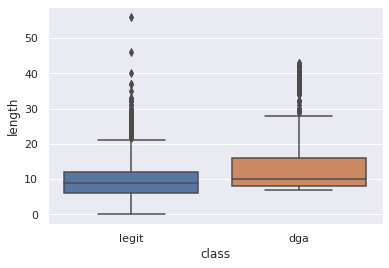

In [113]:
sns.boxplot(x=all_domains['class'],y=all_domains['length'])

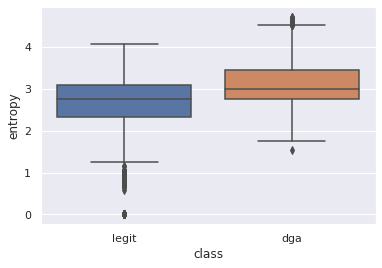

In [114]:
sns.boxplot(x=all_domains['class'],y=all_domains['entropy'])

In [115]:
X = all_domains[['length', 'entropy']]
Y = all_domains[['class']]

/home/sandeepnl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sandeepnl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
[0.42020237 0.5797976 ]


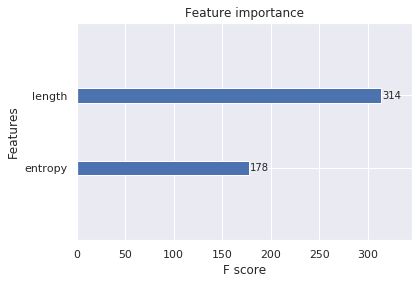

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)
print(model.feature_importances_)

ax = plot_importance(model)
fig = ax.figure
plt.show(fig)

In [117]:
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.66%


In [118]:

alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [119]:
word_dataframe = pd.read_csv('data/words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
# word_dataframe.head(10)

In [120]:
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

In [121]:
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
[0.5635632  0.2303262  0.17513768 0.0309729 ]


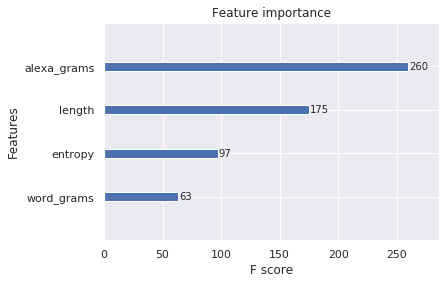

In [122]:
X = all_domains[['length', 'entropy','alexa_grams','word_grams']]
# Y = all_domains[['class']]
Y = np.array(all_domains['class'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

model = XGBClassifier()
model.fit(X_train, y_train)
print(model)
print(model.feature_importances_)

ax = plot_importance(model)
fig = ax.figure
plt.show(fig)

In [123]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.24%


In [124]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.031, n=4, Accuracy: 99.24%
Thresh=0.175, n=3, Accuracy: 99.20%
Thresh=0.230, n=2, Accuracy: 97.66%
Thresh=0.564, n=1, Accuracy: 97.57%


In [125]:
# select features using best threshold 
selection = SelectFromModel(model, threshold=0.035, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9919765418573178
